# Машинное обучение, ФКН ВШЭ

# Практическое задание 9. EM-алгоритм

## Общая информация

Дата выдачи: 18.02.2025

Мягкий дедлайн: 11.03.2025 23:59 MSK

Жёсткий дедлайн: 16.03.2025 23:59 MSK

## Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 15 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-09-em-Username.ipynb
* Модули preprocessing.py, metrics.py, models.py, содержащие написанный вами код
* Ссылки на посылки в Яндекс.Контест для всех функций и классов, которые вы реализовали

Ссылка на Яндекс.Контест: https://contest.yandex.ru/contest/60281

Username — ваша фамилия и имя на латинице именно в таком порядке

# Generative model of Labels, Abilities, and Difficulties (GLAD)

В [семинаре 16](https://github.com/esokolov/ml-course-hse/blob/master/2022-spring/seminars/sem16-em.pdf) мы рассмотрели задачу восстановления истинной разметки по меткам от экспертов (которым мы не можем доверять в полной мере, более того, их предсказания могут расходиться).

Рассмотрим следующую вероятностную модель:

$$ p(L, Z | \alpha, \beta) = \prod_{i=1}^{n} \prod_{j=1}^m \sigma(\alpha_j\beta_i)^{[l_{ij}=z_i]}\sigma(-\alpha_j\beta_i)^{1-[l_{ij}=z_i]} p(z_j)$$

где $l_{ij} -$ ответ $j$-го эксперта на задачу $i$, $z_j -$ истинная разметка, $\alpha_i, \beta_j-$ уровень экспертизы и сложность задачи соответственно. Для более подробного описания модели можно прочитать материалы семинара, а также [оригинальную статью](http://papers.nips.cc/paper/3644-whose-vote-should-count-more-optimal-integration-of-labels-from-labelers-of-unknown-expertise.pdf). Априорное распределение положим равномерным: $p(z_i) = 0.5$.

In [162]:
import numpy as np
seed = 0xDEADF00D
np.random.seed(seed)

In [163]:
L = np.load('L.npy')
n, m = L.shape

**Задание 1. (2 балла)** Реализуйте EM-алгоритм для заданной выше модели. Вы можете воспользоваться предложенными шаблонами или написать свои. 

Обратите внимание, что правдоподобие моделирует не вероятность метки $l_{ij}$ принять значение 1 или 0, а вероятность того, что она равна скрытой переменной $z_i$, т.е. $p(l_{ij} = z_j|z_j, \alpha_j, \beta_i) \neq p(l_{ij} = 1|\alpha_j, \beta_i) $. При этом заранее неизвестно, какая из скрытых переменных соответствует метке 1. Не забывайте, что параметры $\beta_i$ должны быть неотрицательными; для этого оптимизируйте $\log \beta$. На M-шаге можете использовать как один шаг градиентного спуска, так и несколько: разумные результаты у вас должны получаться вне зависимости от числа итераций.

Также при работе с вероятностями не забывайте о точности:
1. Используйте логарифмы вероятностей.
2. $\log \sigma(a)$ лучше преобразовать в $\log \sigma(a) = -\log(1 + \exp(-a)) = -\mathrm{softplus}(-a) $
3. Ещё полезные функции: `scipy.special.expit`, `scipy.special.logsumexp`, `np.log1p`

Для отладки может быть полезно проверить градиент с помощью `scipy.optimize.check_grad`.

In [164]:
from scipy.special import logsumexp, expit
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [165]:
def softplus(x):
    '''stable version of log(1 + exp(x))'''
    c = (x > 20) * 1.
    return np.log1p(np.exp(x * (1-c)) * (1-c)) + x * c

In [158]:
def posterior(alpha, beta, L):
    """ Posterior over true labels z p(z|l, \alpha, \beta)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
    """
    A = np.outer(beta, alpha) 
    log_A = -softplus(-A)
    log_min_A = -softplus(A)
 
    log_p1 = np.sum(L * log_A + (1 - L) * log_min_A, axis=1) + np.log(0.5)
    log_p0 = np.sum((1 - L) * log_A + L * log_min_A, axis=1) + np.log(0.5)
    
    logs = np.vstack([log_p0, log_p1])
    log_norm = logsumexp(logs, axis=0)
    q0 = np.exp(log_p0 - log_norm)
    q1 = np.exp(log_p1 - log_norm)
    
    return np.vstack([q0, q1])


def log_likelihood(alpha, beta, L, z):
    """ p(l=z|z, \alpha, \beta)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        z: ndarray of shape (n_problems).
    """
    A = np.outer(beta, alpha)
    log_A = -softplus(-A)
    log_min_A = -softplus(A)
    correct = (L == z[:, None]).astype(float)
    ll = np.sum(correct * log_A + (1 - correct) * log_min_A, axis=1)
    return np.sum(ll)


def alpha_grad_lb(alpha, beta, L, q):
    """ Gradient of lower bound wrt alpha
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    A = np.outer(beta, alpha)  
    p = expit(A)
    q0, q1 = q[0, :], q[1, :]
    t1 = (1 - p) * (q1[:, None]*L + q0[:, None]*(1 - L))
    t2 = p * (q0[:, None]*L + q1[:, None]*(1 - L))
    grad_alpha = np.sum(beta[:, None] * (t1 - t2), axis=0)
    return grad_alpha


def logbeta_grad_lb(alpha, beta, L, q):
    """ Gradient of lower bound wrt alpha
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    A = np.outer(beta, alpha)  
    p = expit(A)
    q0, q1 = q[0, :], q[1, :]
    
    t1 = (1 - p) * (q1[:, None]*L + q0[:, None]*(1 - L))
    t2 = p * (q0[:, None]*L + q1[:, None]*(1 - L))
    grad_beta = np.sum(alpha[None, :] * (t1 - t2), axis=1)
    grad_logbeta = beta * grad_beta
    return grad_logbeta


def lower_bound(alpha, beta, L, q):
    """ Lower bound
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    A = np.outer(beta, alpha)
    q0, q1 = q[0, :], q[1, :]
    log_sigma_A = -softplus(-A)
    log_sigma_minus_A = -softplus(A)

    ll0 = np.sum((1 - L) * log_sigma_A + L * log_sigma_minus_A, axis=1)  
    ll1 = np.sum(L * log_sigma_A + (1 - L) * log_sigma_minus_A, axis=1)  
    log_prior = np.log(0.5)
    return np.sum(q0 * (ll0 + log_prior - np.log(q0 + 1e-10)) + q1 * (ll1 + log_prior - np.log(q1 + 1e-10)))


In [166]:
def em(L, n_steps=1000, lr=1e-3):
    # initialize parameters
    alpha, logbeta = np.random.randn(m), np.random.randn(n)
    q = np.ones((2, len(logbeta))) * 0.5

    for step in range(n_steps):
        beta = np.exp(logbeta) 
        # E-step
        q = posterior(alpha, beta, L)
        # M-step
        grad_a = alpha_grad_lb(alpha, beta, L, q)
        grad_logb = logbeta_grad_lb(alpha, beta, L, q)
        alpha += lr * grad_a
        logbeta += lr * grad_logb

    return alpha, np.exp(logbeta), q

In [167]:
alpha, beta, q = em(L)

**Задание 2. (1 балл)** Загрузите настоящую разметку. Посчитайте `accuracy` разметки, полученной с помощью обычного голосования по большинству среди экспертов, и сравните его с качеством, полученным с помощью EM-алгоритма. Помните, что алгоритму не важно, какая метка 0, а какая 1, поэтому если получите качество <0.5, то просто поменяйте метки классов (не забудьте также поменять знак у $\alpha$). 

In [170]:
y = np.load('y.npy')

maj = (L.sum(axis=1) >= (L.shape[1] / 2)).astype(int)
acc_maj = accuracy_score(y, maj)
print("Accuracy majority vote: {:.4f}".format(acc_maj))

y_em = (q[1, :] >= 0.5).astype(int)
acc_em = accuracy_score(y, y_em)
if acc_em < 0.5:
    acc_em = accuracy_score(1 - y_em, y)
print("Accuracy EM: {:.4f}".format(acc_em))

Accuracy majority vote: 0.8920
Accuracy EM: 0.9550


**Задание 3. (0.5 балла)** Попробуйте проинтерпретировать полученные коэфициенты $\alpha$. Есть ли в выборке эксперты, которые намеренно голосуют неверно? Как это можно понять по альфам? Продемонстрируйте, что эксперты действительно чаще голосуют за неверный класс. Постройте график зависимости доли врено размеченных экспертом объектов от коэффициента $\alpha$. Прокомментируйте результаты.

In [14]:
print(alpha)

[ 0.65010793  0.764757    4.50283835  0.56511084  0.65578575  4.39194471
  0.6258696   4.14573533 -4.28359763  0.67402502 -4.54606608 -4.43191321
  4.29896537  0.57282234  0.66847691  0.54036452  0.67738697  4.22851257
 -4.20575082  4.16573257]


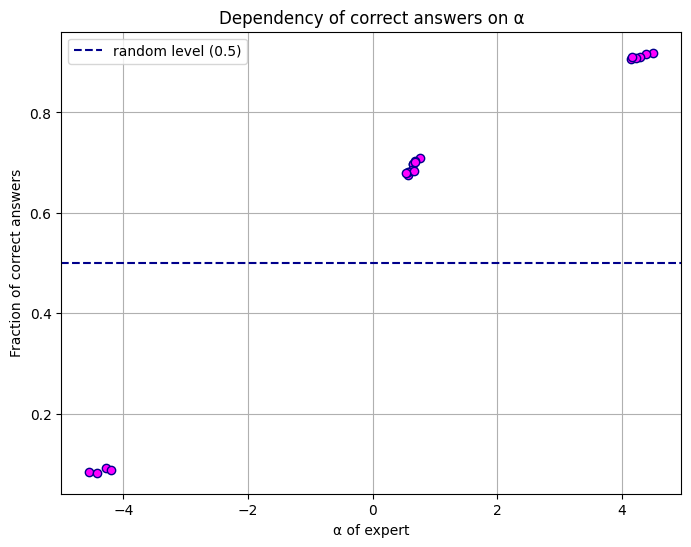

In [22]:
n_experts = L.shape[1]
expert_acc = np.array([np.mean(L[:, j] == y) for j in range(n_experts)])

plt.figure(figsize=(8, 6))
plt.scatter(alpha, expert_acc, color='magenta', edgecolor='darkred')
plt.axhline(0.5, color='darkblue', linestyle='--', label='random level (0.5)')
plt.xlabel('α of expert')
plt.ylabel('Fraction of correct answers')
plt.title('Dependency of correct answers on α')
plt.legend()
plt.grid(True)
plt.show()

Можем заметить, что если у эксперта отрицательное значение альфа (меньше -4), доля верных ответов для него ниже рандомной, что показывает, что он намеренно голосует неверно. 

Эксперты с положительным значением альфа имеют долю верных ответов выше 0.6, а значит голосуют согласно своему уровню экспертности

**Задание 4. (бонус, 2 балла)**  Как уже было замечено выше, модели не важно, какой класс 1, а какой 0. Скажем, если все эксперты оказались максимально противными и ставят метку с точностью наоборот, то у вас будет полная согласованность между экспертами, при этом невозможно понять правильно они разметили выборку или нет, смотря только на такую разметку. Чтобы избежать этого, можно включать в выборку вопрос с заведомо известным ответом, тогда вы сможете определить, ставит ли эксперт специально неверные метки.

Чтобы обощить данную модель на случай заданий с заведомо известной меткой, достоточно не делать для них E-шаг, а всегда полагать апостериорное распределение вырожденным в истинном классе. Реализуйте данную модель и используйте истинную разметку *для нескольких* задач из обучения. Проинтерпретируйте полученные результаты.

In [78]:
def em_with_answers(L, n_steps=1000, lr=1e-3, k_indices=None, y_known=None):
    np.random.seed(124)
    alpha, logbeta = np.random.randn(m), np.random.randn(n)
    q = np.ones((2, n)) * 0.5

    if k_indices is not None and k_indices.size > 0:
        q[0, k_indices] = 1 - y_known
        q[1, k_indices] = y_known

    u_indices = np.delete(np.arange(n), k_indices) if k_indices is not None and k_indices.size > 0 else np.arange(n)
    L_u = L[u_indices, :]

    for step in range(n_steps):
        beta = np.exp(logbeta)
        beta_unknown = beta[u_indices]
        q[:, u_indices] = posterior(alpha=alpha, beta=beta_unknown, L=L_u)
        grad_alpha = alpha_grad_lb(alpha=alpha, beta=beta, L=L, q=q)
        grad_logbeta = logbeta_grad_lb(alpha=alpha, beta=beta, L=L, q=q)
        alpha += lr * grad_alpha
        logbeta += lr * grad_logbeta

    return alpha, np.exp(logbeta), q


In [82]:
known = [0, 70, 150, 550, 700, 900, 1000]
results = []

for count in known:
    alpha, beta, q = em_with_answers(L, n_steps=1000, lr=1e-3, k_indices=np.arange(count), y_known=y[:count])
    y_em = np.argmax(q, axis=0)
    em_acc = accuracy_score(y_em, y)
    if em_acc < 0.5:
        em_acc = accuracy_score(1 - y_em, y)
    results.append(em_acc)
        
    print(f'{count} known answers: accuracy {em_acc}')

0 known answers: accuracy 0.9555
70 known answers: accuracy 0.9575
150 known answers: accuracy 0.9595
550 known answers: accuracy 0.968
700 known answers: accuracy 0.9725
900 known answers: accuracy 0.9785
1000 known answers: accuracy 0.9795


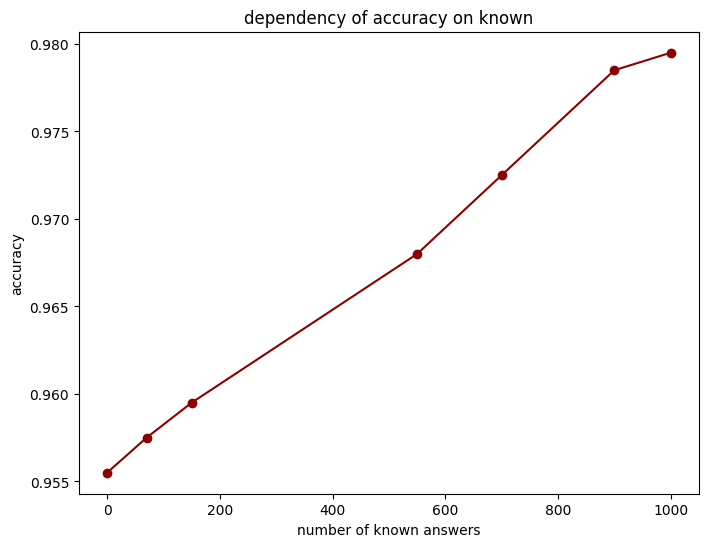

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(known, results, marker='o', linestyle='-', color='darkred')
plt.xlabel('number of known answers')
plt.ylabel('accuracy')
plt.title('dependency of accuracy on known answers')
plt.show()

Получается, чем больше у нас истинных известных ответов, тем больше становится точность модели. Прирост качества получился достаточно неплохой, по сравнению с обычной реализацией glad

# Выравнивание слов (Word Alignment)

EM-алгоритм также применяют на практике для настройки параметров модели выравнивания слов, более сложные модификации которой используются в статистическом машинном переводе. Мы не будем подробно обсуждать применение word alignment для перевода и ограничимся следующей целью: пусть у нас есть параллельный корпус из предложений на исходном языке и их переводов на целевой язык (в этом задании используются английский и чешский соответственно). 

Первая задача — определить с помощью этого корпуса, как переводится каждое отдельное слово на целевом языке. Вторая задача — для произвольной пары из предложения и его перевода установить, переводом какого слова в исходном предложении является каждое слово в целевом предложении. Оказывается, у обеих задач существует элегантное и эффективное решение при введении правильной вероятностной модели: в этой части задания вам предстоит его реализовать и оценить результаты работы. Но обо всём по порядку :)

---

Перед тем, как заниматься машинным обучением, давайте разберёмся с данными и метриками в интересующей нас задаче. В ячейке ниже загружается и разархивируется параллельный английско-чешский корпус, в котором есть разметка выравнивания слов. Нетрудно заметить, что формат XML-файла, использованный его авторами, не вполне стандартный: нет готовой команды , которая позволила бы получить список пар предложений вместе с выравниваниями. Это значит, что нужно разобраться с форматом и написать парсер самостоятельно, используя встроенные средства Python, например, модуль [xml](https://docs.python.org/3.7/library/xml.html).

In [128]:
%%bash
wget -q https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-1804/CzEnAli_1.0.tar.gz -O CzEnAli_1.0.tar.gz
mkdir -p data
tar -xzf CzEnAli_1.0.tar.gz -C data/
head -n 20 data/merged_data/project_syndicate/project_syndicate_bacchetta1.wa

<?xml version="1.0" encoding="utf-8" ?>
<sentences>
<s id="project_syndicate_bacchetta1-s1">
  <english>Are the Dollar 's Days Numbered ?</english>
  <czech>Jsou dny dolaru sečteny ?</czech>
  <sure>1-1 3-3 5-2 6-4 7-5</sure>
  <possible>2-2 4-3</possible>
</s>
<s id="project_syndicate_bacchetta1-s2">
  <english>Philippe Bacchetta and Eric van Wincoop</english>
  <czech>Philippe Bacchetta and Eric van Wincoop</czech>
  <sure>1-1 2-2 3-3 4-4 5-5 6-6</sure>
  <possible></possible>
</s>
<s id="project_syndicate_bacchetta1-s3">
  <english>A year ago , the dollar bestrode the world like a colossus .</english>
  <czech>Ještě před rokem dolar dominoval světu jako imperátor .</czech>
  <sure>10-7 12-8 13-9 2-3 3-2 6-4 7-5 9-6</sure>
  <possible>1-3 11-8 3-1 5-4 8-6</possible>
</s>


**Задание -2. (0.5 балла)** Реализуйте функцию `extract_sentences`, которая принимает на вход путь к файлу с XML-разметкой, используемой в этом датасете, и возвращает список параллельных предложений, а также список из «уверенных» (sure) и «возможных» (possible) пар выравниваний. Отправьте вашу реализацию в Яндекс.Контест, чтобы убедиться в её корректности; в следующей ячейке ноутбука соберите все пары размеченных предложений из датасета в два списка `all_sentences` (список `SentencePair`) и `all_targets` (список LabeledAlignment).

Здесь и далее соблюдайте сигнатуры функций и пользуйтесь объявленными в модуле `preprocessing.py` классами для организации данных. Стоит заметить, что предложения уже токенизированы (даже отделена пунктуация), поэтому предобработку текстов совершать не нужно. Обратите внимание на формат хранения выравниваний: нумерация начинается с 1 (в таком виде и нужно сохранять), первым в паре идёт слово из англоязычного предложения.

Ссылка на посылку: https://contest.yandex.ru/contest/60281/run-report/134607610/

In [129]:
import os
import glob
from preprocessing import extract_sentences

all_sentences = []
all_targets = []
#all_sentences, all_targets = extract_sentences('data/merged_data/project_syndicate/project_syndicate_bacchetta1.wa')
for filepath in glob.glob(os.path.join('data', 'merged_data', '**', '*.wa'), recursive=True):
    sents, targets = extract_sentences(filepath)
    all_sentences.extend(sents)
    all_targets.extend(targets)

In [21]:
print(all_sentences)
print(all_targets)

[SentencePair(source=['Are', 'the', 'Dollar', "'s", 'Days', 'Numbered', '?'], target=['Jsou', 'dny', 'dolaru', 'sečteny', '?']), SentencePair(source=['Philippe', 'Bacchetta', 'and', 'Eric', 'van', 'Wincoop'], target=['Philippe', 'Bacchetta', 'and', 'Eric', 'van', 'Wincoop']), SentencePair(source=['A', 'year', 'ago', ',', 'the', 'dollar', 'bestrode', 'the', 'world', 'like', 'a', 'colossus', '.'], target=['Ještě', 'před', 'rokem', 'dolar', 'dominoval', 'světu', 'jako', 'imperátor', '.']), SentencePair(source=['Now', 'it', 'is', 'humbled', 'and', 'the', 'euro', 'looks', 'triumphant', '.'], target=['Teď', 'je', 'pokořen', 'a', 'triumfuje', 'euro', '.']), SentencePair(source=['Is', 'the', 'dollar', 'on', 'the', 'way', 'out', 'as', 'the', 'world', "'s", 'unchallenged', 'reserve', 'and', 'trade', 'currency', '?'], target=['Přestává', 'dolar', 'být', 'nezpochybnitelnou', 'rezervní', 'a', 'obchodní', 'měnou', '?']), SentencePair(source=['Or', 'is', '"', 'euro', 'triumphalism', '"', 'premature',

**Задание -1. (0.5 балла)** Реализуйте функции `get_token_to_index` и `tokenize_sents` из модуля `preprocessing.py`, постройте словари token->index для обоих языков и постройте список из `TokenizedSentencePair` по выборке. Реализации функций также отправьте в Яндекс.Контест.

Ссылка на посылку: https://contest.yandex.ru/contest/60281/run-report/134601351/

In [4]:
%load_ext autoreload
%autoreload 2

In [130]:
from preprocessing import get_token_to_index, tokenize_sents

t_idx_src, t_idx_tgt = get_token_to_index(all_sentences)
tokenized_sentences = tokenize_sents(all_sentences, t_idx_src, t_idx_tgt)

В качестве бейзлайна для этой задачи мы возьмём способ выравнивания слов по коэффициенту Дайса: слово в исходном языке является переводом слова на целевом языке, если они часто встречаются в одних и тех же предложениях и редко встречаются по отдельности. 

Математически это записывается по аналогии с мерой Жаккара: пусть $c(x,y)$ — число параллельных предложений, в которых есть и $x$ (на исходном языке), и $y$ (на целевом языке), а $c(x)$ и $c(y)$ — суммарное количество предложений, в которых встречается слово $x$ и $y$ соответственно. Тогда $\textrm{Dice}(x,y)=\frac{2 \cdot c(x,y)}{c(x) + c(y)}$ — характеристика «похожести» слов $x$ и $y$. Она равна 1, если слова встречаются только в контексте друг друга (не бывает предложений только со словом $x$ без $y$ в переводе и наоборот), равна 0, если слова никогда не встречаются в параллельных предложениях и находится между пороговыми значениями в остальных случаях.

В файле `models.py` описан абстрактный класс `BaseAligner`, наследником которого должны являться все модели в задании, а также приведён пример реализации `DiceAligner` выравнивания слов описанным выше путём. Ниже вы можете увидеть, как применять эту модель.

In [131]:
from models import DiceAligner

baseline = DiceAligner(len(t_idx_src), len(t_idx_tgt), threshold=0.01)
baseline.fit(tokenized_sentences)

Чтобы оценить качество модели выравнивания, пользуясь имеющейся разметкой, существует ряд автоматических метрик. Они подразумевают, что в разметке есть два вида выравниваний — «уверенные» (sure) и «возможные» (possible). Обозначим для конкретного предложения первое множество выравниваний $S$, второе — $P$, а предсказанные выравнивания — $A$; причём, в отличие от разметки в файле, $S\subseteq P$. Тогда можно предложить три метрики, используя только операции над этими множествами:

Precision $=\frac{|A\cap P|}{|A|}$. Отражает, какая доля предсказанных нами выравниваний вообще корректна; если мы дадим в качестве ответа все возможные пары слов в предложении, эта метрика сильно просядет.

Recall $=\frac{|A\cap S|}{|S|}$. Эта метрика показывает, какую долю «уверенных» выравниваний мы обнаружили. Если мы попытаемся сделать слишком консервативную модель, которая выдаёт 0 или 1 предсказание на нетривиальных предложениях, полнота получится крайне низкая. 

Alignment Error Rate (AER) $=1-\frac{|A\cap P|+|A\cap S|}{|A|+|S|}$. Метрика является комбинацией двух предыдущих и отслеживает общее качество работы системы, штрафуя оба описанных выше вида нежелаемого поведения модели. 

**Задание 0. (0.5 балла)** Реализуйте функции compute_precision, compute_recall, compute_aer из модуля metrics.py. Оцените качество бейзлайнового метода. Обратите внимание, что нужно использовать микро-усреднение во всех функциях: необходимо просуммировать числитель и знаменатель по всем предложениям и только потом делить.

Ссылка на посылку: https://contest.yandex.ru/contest/60281/run-report/134607086/

In [24]:
from metrics import compute_aer

compute_aer(all_targets,baseline.align(tokenized_sentences))

0.8074618330841489

Теперь мы можем перейти к базовой вероятностной модели для выравнивания слов. Пусть $S=(s_1,\ldots,s_n)$ исходное предложение, $T=(t_1,\ldots,t_m)$ — его перевод. В роли латентных переменных будут выступать выравнивания $A=(a_1,\ldots,a_m)$ каждого слова в целевом предложении, причём $a_i\in\{1,\ldots,n\}$ (считаем, что каждое слово в $t$ является переводом какого-то слова из $s$). Параметрами модели является матрица условных вероятностей перевода: каждый её элемент $\theta(y|x)=p(y|x)$ отражает вероятность того, что переводом слова $x$ с исходного языка на целевой является слово $y$ (нормировка, соответственно, совершается по словарю целевого языка). Правдоподобие латентных переменных и предложения на целевом языке в этой модели записывается так:

$$
p(A,T|S)=\prod_{i=1}^m p(a_i)p(t_i|a_i,S)=\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i}).
$$ 

**Задание 1. (2 балла)** Выведите шаги EM-алгоритма для этой модели, а также получите выражение для подсчёта нижней оценки правдоподобия ($\mathcal{L}$ в обозначениях лекции и семинара). **Обратите внимание, что на M-шаге нужно найти аналитический максимум по параметрам.**

Имеем следующий вид $$p(A,T|S)=\prod_{i=1}^m p(a_i)p(t_i|a_i,S)=\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i}) $$На Е-шаге необходимо найти $p(A|T,S)$. Распишем Е-шаг:

$$ q^{*}(A) = p(A|T,S) = \dfrac{p(A,T|S)}{p(T|S)} = \dfrac{\prod_{i=1}^m p(a_i)p(t_i|a_i,S)}{\displaystyle{\sum_{A}} \prod_{i=1}^m p(a_i)p(t_i|a_i,S)} = \left[p(a_i) = \dfrac{1}{n}\right] =\dfrac{\prod_{i=1}^m \dfrac{1}{n}p(t_i|a_i,S)}{\displaystyle{\sum_{A}} \prod_{i=1}^m \dfrac{1}{n}p(t_i|a_i,S)} $$

$$ q^{*}(a_i) = P(a_i|T, S)= \dfrac{p(a_i,T|S)}{\displaystyle{\sum_{k=1}^{n}} p(a_k,T|S)} = \dfrac{\theta(t_i|s_{a_i})}{\displaystyle{\sum_{k=1}^{n}}\theta(t_i|s_{_k})}$$

На М шаге максимизируем матож логарифма полного правдоподобия 

$$\sum_{A} p(A | T, S) \log p(A, T | S) = \sum_{A} p(A | T, S) \sum_{i=1}^{m} \log \theta(t_i | s_{a_i}) = \sum_{i=1}^{m} \sum_{j=1}^{n} p(a_i = j | T, S) \log \theta(t_i | s_j) \to \max s. \sum_{y} \theta(y | x) = 1$$

Максимизируем с условием по тета, так как это матрица условных вероятностей. Лагранжиан: 

$$
\mathcal{L} = \sum_{i=1}^{m} \sum_{j=1}^{n} p(a_i = j | T, S) \log \theta(t_i | s_j) + \sum_{x} \lambda_x \left( \sum_{y} \theta(y | x) - 1 \right)
$$
$$
\frac{\partial \mathcal{L}}{\partial \theta(y | x)} = \sum_{i=1}^{m} \sum_{j=1}^{n} p(a_i = j | T, S) \frac{\delta_{t_i, y} \delta_{s_j, x}}{\theta(y | x)} + \lambda_x = 0
$$

$$
\theta(y | x) = -\frac{1}{\lambda_x} \sum_{i=1}^{m} \sum_{j=1}^{n} p(a_i = j | T, S) \delta_{t_i, y} \delta_{s_j, x}
$$

Из условия на тета:

$$
\sum_{y} \theta(y | x) = 1 \Rightarrow \lambda_x = - \sum_{i=1}^{m} \sum_{j=1}^{n} p(a_i = j | T, S) \delta_{s_j, x}
\Rightarrow
\theta(y | x)^{*} = \frac{\sum_{i=1}^{m} \sum_{j=1}^{n} p(a_i = j | T, S) \delta_{t_i, y} \delta_{s_j, x}}{\sum_{i=1}^{m} \sum_{j=1}^{n} p(a_i = j | T, S) \delta_{s_j, x}}
$$

$$\theta(y | x)^{*} = \frac{\displaystyle{\sum_{i: t_i=y} \displaystyle{\sum_{j: s_j=x}} p(a_i = j | T, S)}}{\displaystyle{\sum_{i=1}^{m} \sum_{j: s_j=x} p(a_i = j | T, S)}}$$

Для нижней оценки правдоподобия, используем:

$$
\log p(T | S) = \sum_{A} p(A | T, S) \log p(T, A | S) - \sum_{A} p(A | T, S) \log p(A | T, S)
$$

Рассмотрим отдельно оба слагаемых:

1) первое слагаемое:

$$
\mathbb{E}_{q}[\log p(T, A | S)] 
= \sum_{A} q(A) \log p(A, T | S)
= \sum_{i=1}^m \sum_{j=1}^n q(a_i = j) \log p(a_i) + \log p(t_i | s_j) $$ 
$$\left[p(a_i) = \frac{1}{n}\right] \Rightarrow \log p(A, T | S) =\sum_{i=1}^m \sum_{j=1}^n q(a_i = j) \log \frac{1}{n} + \log \theta(t_i | s_j) = -m \log n + \sum_{i=1}^m \log \theta(t_i | s_{a_i})
$$

$$
\mathbb{E}_{q}[\log p(A, T | S)] = \sum_{i=1}^m \sum_{j=1}^n q(a_i = j) \left( \log \theta(t_i | s_j) - \log n \right)= \sum_{i=1}^m \sum_{j=1}^n q(a_i = j) \log \theta(t_i | s_j) - \sum_{i=1}^m \log n
$$

2) энтропия:

$$
H(q) = - \sum_{i=1}^m \sum_{j=1}^n q(a_i = j) \log q(a_i = j)
$$
То есть для каждого целевого слова $ \left( t_i \right) $ находим

$$
- \sum_{j: q(a_i = j) > 0} q(a_i = j) \log q(a_i = j)
$$

**Задание 2. (2.5 балла)** Реализуйте все методы класса `WordAligner` в соответствии с полученными вами формулами. Протестируйте вашу реализацию через Яндекс.Контест, а здесь обучите модель и посчитайте её AER на истинной разметке. Чтобы предсказать выравнивание для пары предложений в этой модели, следует выбирать в соответствие для слова в целевом предложении с индексом $i$ позицию, соответствующую максимуму апостериорного распределения $p(a_i|T,S)$.

Ссылка на посылку: я извиняюсь, но я не хочу больше мучаться с ml и tl (осталась только ml по итогу)

RE у меня не возникает, так что сам результат по идее верный, но память не чинится

https://contest.yandex.ru/contest/60281/run-report/134956276/

In [132]:
from models import WordAligner

word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 20)
word_aligner.fit(tokenized_sentences)

aer = compute_aer(all_targets, word_aligner.align(tokenized_sentences))
print(f"AER: {aer:.4f}")

AER: 0.5749


Заметим, что таблицу вероятностей перевода можно использовать и саму по себе для построения словарей. Пример работы показан ниже: метод хоть и работает, но мягко говоря, неидально — слишком мало данных.

In [133]:
idx_token_tgt = {index:token for token, index in t_idx_tgt.items()}

In [134]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mr']].argsort()[-3:]]

['Pan', 'řekl', 'pan']

In [135]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mrs']].argsort()[-3:]]

['-', 'Mannová', 'paní']

In [41]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['water']].argsort()[-3:]]

['z', 'pro', 'vody']

In [42]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['depended']].argsort()[-3:]]

['jež', 'překupničením', 'koni']

In [43]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['on']].argsort()[-3:]]

['.', 'se', 'na']

**Задание 3. (0.5 балла)** Мы смогли получить матрицу условных вероятностей перевода исходного языка в целевой. Можно ли, пользуясь этой матрицей и ещё какими-то статистиками по параллельному корпусу, получить вероятности перевода целевого языка в исходный? Реализуйте такой метод и приведите ниже пример его работы, показав пару удачных переводов.

In [ ]:
import numpy as np

def calculate_language_priors(sentences_iter, vocabulary_size):
    word_counts = {}
    total_words = 0
    for tokens in sentences_iter:
        for token in tokens:
            word_counts[token] = word_counts.get(token, 0) + 1
            total_words += 1
    
    prior_probabilities = np.zeros(vocabulary_size)
    for token, count in word_counts.items():
        prior_probabilities[token] = count / total_words
    
    return prior_probabilities

english = calculate_language_priors((pair.source_tokens for pair in tokenized_sentences),len(t_idx_src))
czech = calculate_language_priors((pair.target_tokens for pair in tokenized_sentences),len(t_idx_tgt))
en_to_cz = word_aligner.translation_probs
cz_to_en = en_to_cz * english[:, np.newaxis] / np.maximum(czech, 1e-10)
reversed_src_dict = {idx: word for word, idx in t_idx_src.items()}

In [74]:
def get_translation_from_czech(czech_word):
    if czech_word not in t_idx_tgt:
        return "<<unknown>>"
    czech_idx = t_idx_tgt[czech_word]
    best_english_idx = np.argmax(cz_to_en[:, czech_idx])
    return reversed_src_dict[best_english_idx]

example_words = ["Evropa", "peníze", "země", "vláda", "ekonomika", "trh", "obchodní"]
for word in example_words:
    print(f"{word} → {get_translation_from_czech(word)}")

Evropa → Europe
peníze → money
země → country
vláda → government
ekonomika → economy
trh → market
obchodní → trade


**Задание 4. (0.5 балла)** Визуализируйте полученные выравнивания для нескольких предложений в виде heatmap: по одной из осей располагаются токены исходного текста, по другой — токены его перевода, на пересечении позиций $i$ и $j$ — 0 либо 1 в зависимости от того, является ли в обученной модели $a_i$ равным $j$. Можете ли вы их проинтерпретировать? Постройте аналогичный график, но без дискретизации, а визуализируя напрямую апостериорное распределение. Можете ли вы найти ситуации, в которых модель не уверена, переводом какого слова является слово $i$?

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_posteriors(model, sentence_pair):
    #matrix of p(a_i|T,S)
    m = len(sentence_pair.target_tokens)
    n = len(sentence_pair.source_tokens)
    posteriors = np.zeros((m, n))
    for i, target_idx in enumerate(sentence_pair.target_tokens):
        for j, source_idx in enumerate(sentence_pair.source_tokens):
            translation_prob = model.translation_probs[source_idx, target_idx]
            posteriors[i, j] = translation_prob

        if np.sum(posteriors[i]) > 0:
            posteriors[i] /= np.sum(posteriors[i])
    
    return posteriors

In [137]:
def visualize_alignment(sentence_pair, model, discrete=True):
    src_tokens = [reversed_src_dict[idx] for idx in sentence_pair.source_tokens]
    tgt_tokens = [idx_token_tgt[idx] for idx in sentence_pair.target_tokens]
    posteriors = get_posteriors(model, sentence_pair)
    
    if discrete: #turn probs into 0/1
        alignments = np.zeros_like(posteriors)
        for i in range(posteriors.shape[0]):
            if posteriors.shape[1] > 0:  
                alignments[i, np.argmax(posteriors[i])] = 1
        data = alignments
        title = "Discrete Probs"
        cmap = "crest"
    else:
        data = posteriors
        title = "Posterior Probabilities"
        cmap = "crest"
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, cmap=cmap, linewidths=.5, xticklabels=src_tokens, yticklabels=tgt_tokens, annot=True, fmt=".1f")
    plt.xlabel('English words')
    plt.ylabel('Czech words')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


English: But the role of size is more complex than it seems .
Czech: Jenomže velikost je mnohem komplexnější činitel , než jak se na první pohled zdá .
--------------------------------------------------


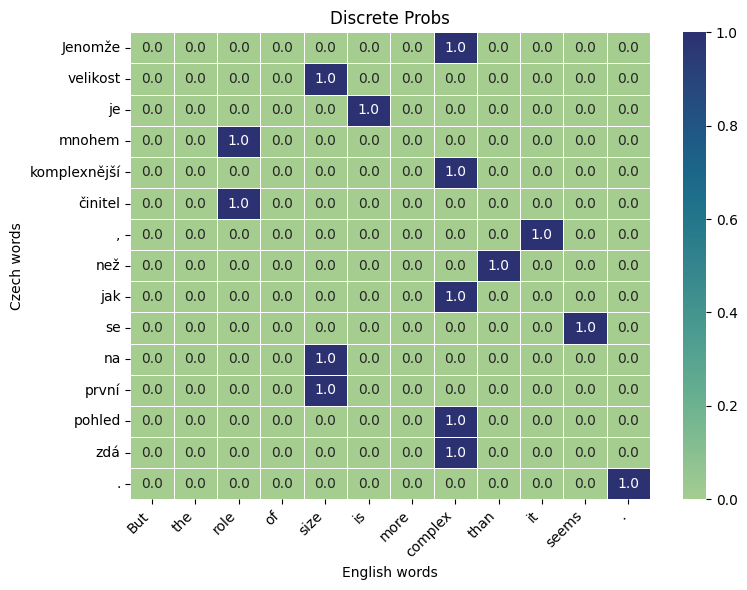

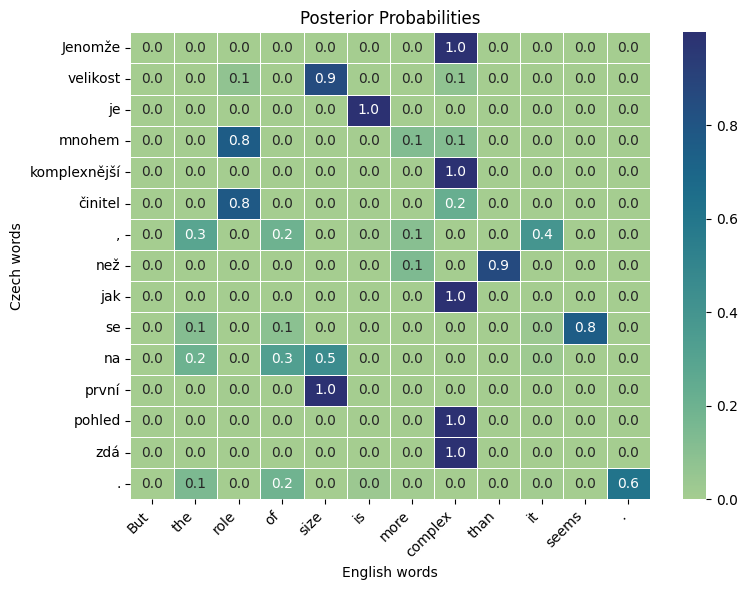

English: Consider a Japanese firm seeking to make the highest yen profits on goods sold in Switzerland .
Czech: Například japonská firma , jíž jde o co nejvyšší zisk v jenech ze zboží prodávaného ve Švýcarsku .
--------------------------------------------------


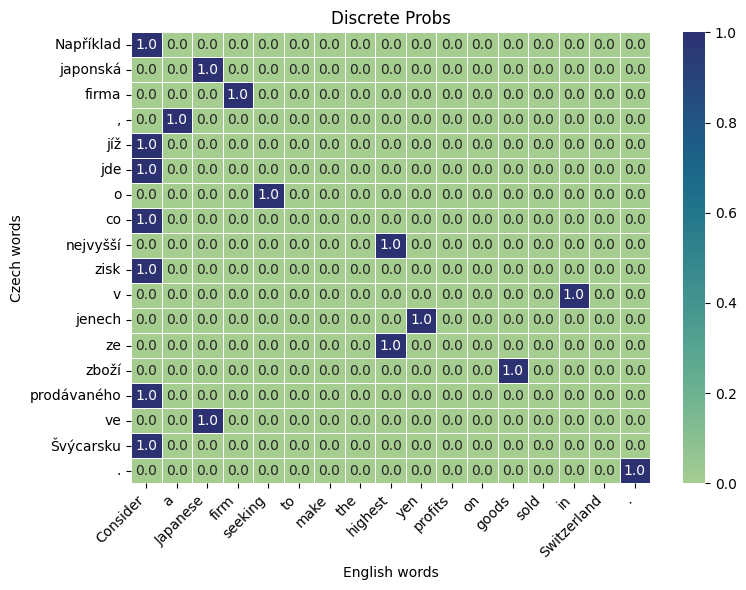

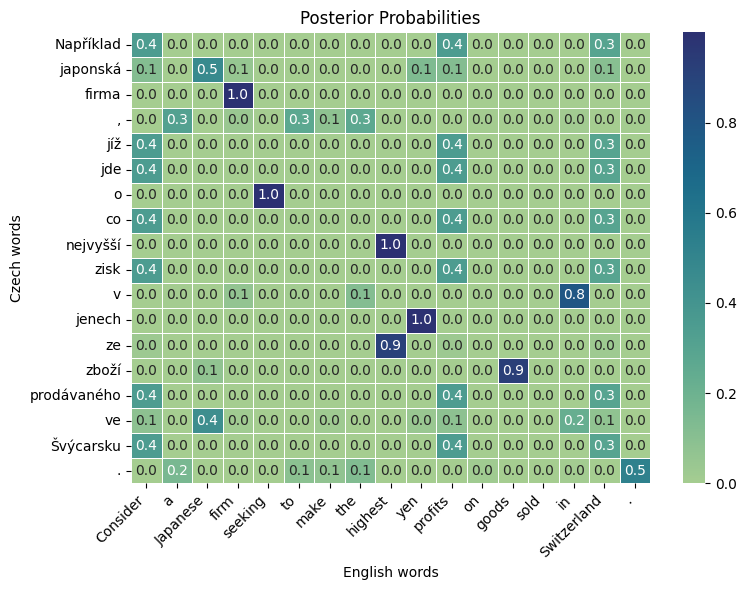

English: Because Japan has the second largest economy in the world , the yen should be a more important currency .
Czech: Japonsko je druhá největší světová ekonomika . Jen by tedy měl mít mnohem větší váhu .
--------------------------------------------------


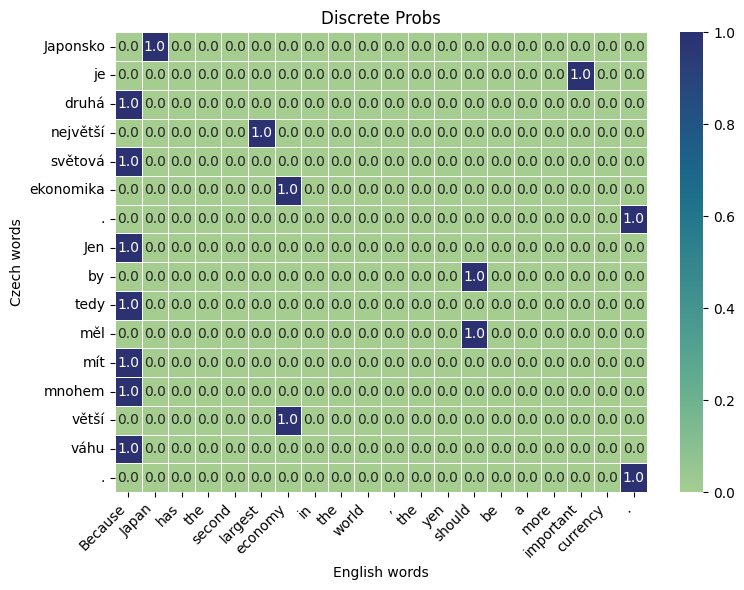

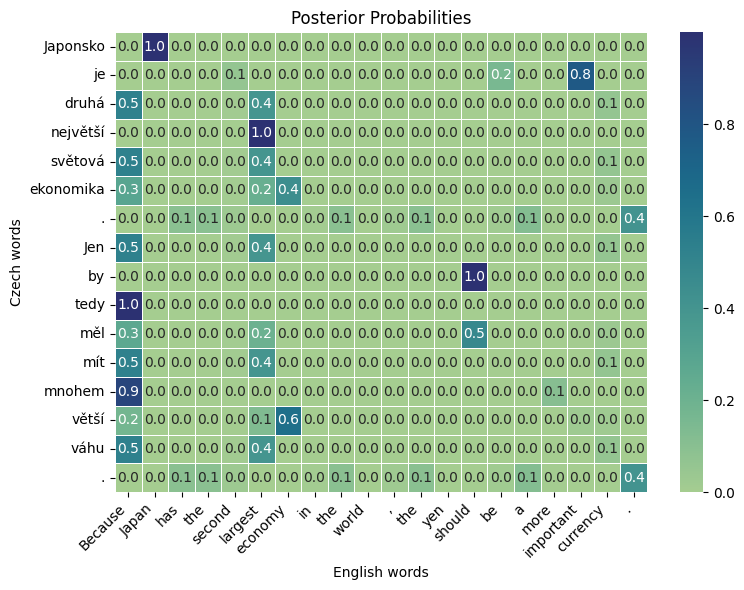

English: Yet these changes will only occur gradually .
Czech: K těmto změnám ovšem dojde postupně .
--------------------------------------------------


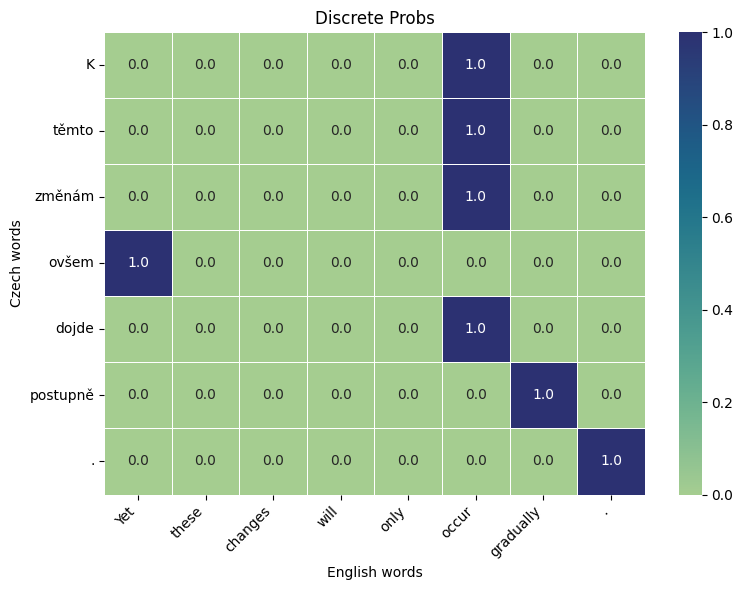

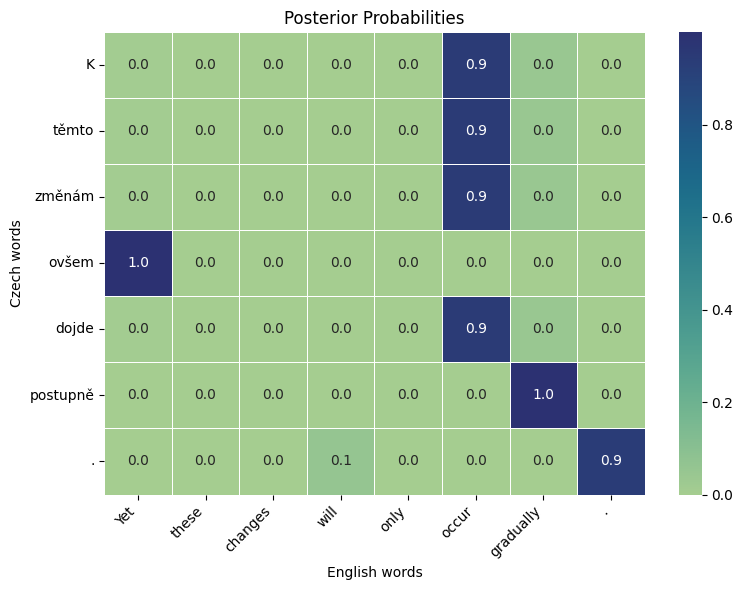

English: Others argue that the old myths should be abandoned in favor of a bold move forward .
Czech: Jiní tvrdí , že je třeba se zbavit starých mýtů a vykročit odvážně vpřed .
--------------------------------------------------


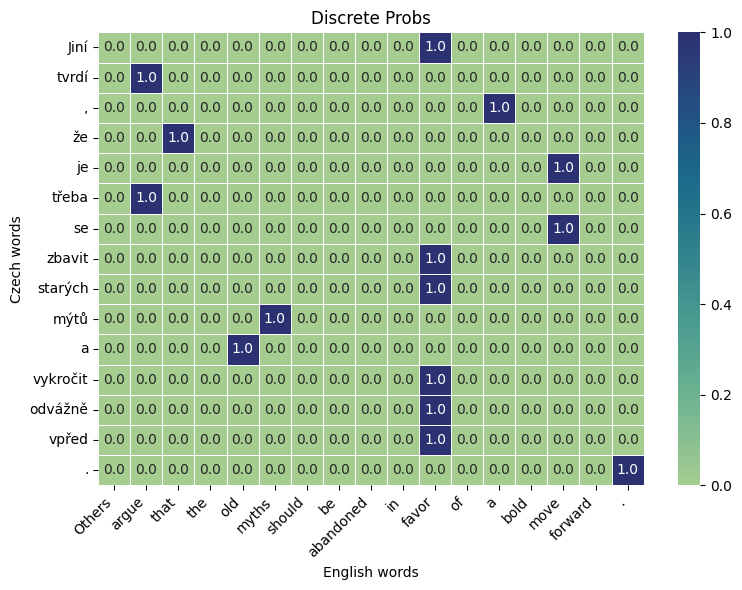

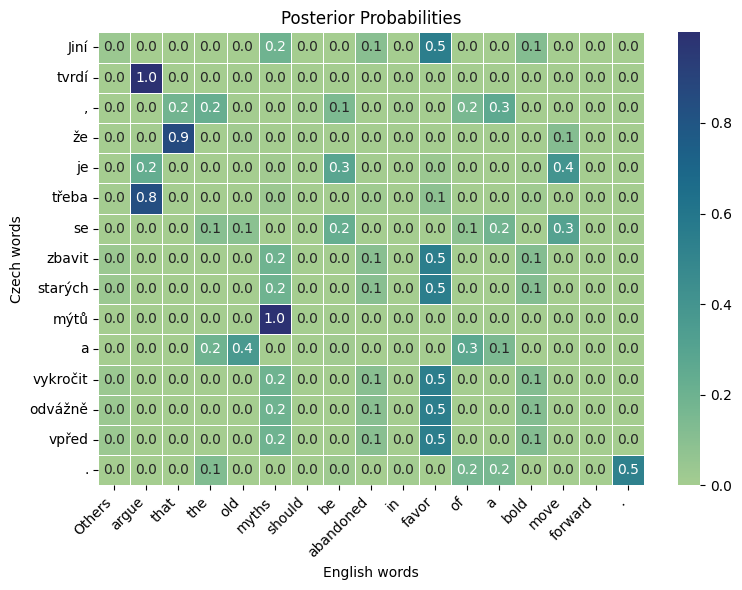

In [ ]:
sample = [15, 20, 30, 41, 50] 
for idx in sample:
    if idx < len(tokenized_sentences):
        sentence_pair = tokenized_sentences[idx]
        src_tokens = [reversed_src_dict[idx] for idx in sentence_pair.source_tokens]
        tgt_tokens = [idx_token_tgt[idx] for idx in sentence_pair.target_tokens]
        print(f"English: {' '.join(src_tokens)}")
        print(f"Czech: {' '.join(tgt_tokens)}")
        print("-" * 50)
        
        visualize_alignment(sentence_pair, word_aligner, discrete=True)
        visualize_alignment(sentence_pair, word_aligner, discrete=False)

**В дискретной версии**:
Каждая синяя ячейка показывает, что модель считает чешское слово (ось Y) переводом английского слова (ось X), и для каждого чешского слова выбирается только одно английское (тут бывают достаточно странные случаи похожих переводов, типо перевода на occur в предпоследнем примере)

**В непрерывной версии**:
Здесь можно увидеть моменты, где модель не уверена между несколькими вариантами - например, где слова имеют близкие вероятности и нет уверенности между вариантами выранивания

Неуверенность часто видно на предлогах, артиклях или названиях, где может быть несколько возможных выравниваний

Заметим, что при задании модели мы сделали довольно сильное предположение о том, что вероятности выбора слова для выравнивания никак не зависят от позиции слова в целевом предложении. Можно сделать эти вероятности настраиваемыми параметрами, получив прямоугольную матрицу $\phi_{m,n}(j|i)=p(a_i=j|m,n)$ для каждой пары длин предложений $m,n$: по-прежнему мы получаем распределение над индексами в исходном предложении. Тогда модель приобретает вид
$$
p(A,T|S)=\prod_{i=1}^m p(a_i|m,n)p(t_i| a_i, S)=\prod_{i=1}^m \phi_{m,n}(a_i|i)\theta(t_i|s_{a_i}).
$$

**Задание 5. (1.5 балла)** Выведите шаги EM-алгоритма для этой модели, а также получите выражение для подсчёта нижней оценки правдоподобия.


заменяем равномерное распределение $p(a_i) = \dfrac{1}{n}$ на распределение $φ_m,n(a_i|i) = p(a_i|m,n)$ для каждой пары длин предложений (m, n)

Рассмотрим Е-шаг: 

$$
q(A) =p(A|T,S) = \dfrac{p(A,T|S)}{p(T|S)} =  \dfrac{\displaystyle{\prod_{i=1}^m} \phi_{m,n}(a_i|i) \cdot \theta(t_i|s_{a_i})}{\displaystyle{\sum_{A} \prod_{i=1}^m}\phi_{m,n}(a_i|i) \cdot \theta(t_i|s_{a_i})}
$$

$$
\Rightarrow q(a_i) = p(a_i|T,S) = \dfrac{\phi_{m,n}(a_i|i)  \theta(t_i|s_{a_i})}{\displaystyle{\sum_{j=1}^{m}} \phi_{m,n}(j|i) \theta(t_i|s_{j})}
$$

Рассмотрим М-шаг: максимизируем матож логарифма полного правдоподобия (c учетом независимости выравниваний $a_i$)

$$
Q(\theta, \phi) = \displaystyle{\sum_{A}} p(A|T,S) \cdot \log p(A,T|S) = 
\displaystyle{\sum_{A}} p(A|T,S) \cdot \displaystyle{\sum_{i=1}^m} \log(\phi_{m,n}(a_i|i) \cdot \theta(t_i|s_{a_i})) = 
$$
$$= \displaystyle{\sum_{A}} p(A|T,S) \cdot \displaystyle{\sum_{i=1}^m} \left(\log \phi_{m,n}(a_i|i) + \log \theta(t_i|s_{a_i})\right) = \displaystyle{\sum_{i=1}^m \sum_{j=1}^n} p(a_i = j|T, S)\left(\log \phi_{m,n}(j|i) + \log \theta(t_i|s_{j})\right)
$$

Ограничения в оптимизационной задаче следующие: $\sum_{y} \theta(y|x) = 1, \displaystyle{\sum_{j}} \phi_{m,n}(j|i) = 1$, запишем Лагранжиан

$$

\mathcal{L} = Q(\theta, \phi) + \displaystyle{\sum_{x}} \lambda_{x} \left(\displaystyle{\sum_{y}} y \theta(y|x) -1\right) + \displaystyle{\sum_{i}} \mu_{i} \left(\displaystyle{\sum_{j}} \phi_{m,n}(j|i) -1\right) \to \displaystyle{\max}
$$

$$
\dfrac{\delta \mathcal{L}}{\delta \theta(y|x)} = \dfrac{\displaystyle{\sum_{i: t_i = y} \sum_{j: s_j= x}}p(a_i = j|T, S)}{\theta(y|x)} - \lambda_{x} = 0 \Rightarrow \theta(y|x) = \dfrac{\displaystyle{\sum_{i: t_i = y} \sum_{j: s_j= x}}p(a_i = j|T, S)}{\lambda_{x}}$$

$$
\sum_{y} \theta(y|x) = 1 \Rightarrow \lambda_{x} = \displaystyle{\sum_{y} \sum_{i: t_i = y}\sum_{j: s_j= x}}p(a_i=j|T,S) =\sum_{i=1}^{m} \sum_{j: s_j= x} p(a_i = j|T, S) $$
$$
\Rightarrow \theta(y|x)^{*} = \dfrac{\displaystyle{\sum_{i: t_i = y} \sum_{j: s_j= x}}p(a_i = j|T, S)}{\displaystyle{\sum_{i = 1}^{m} \sum_{j: s_j= x}}p(a_i = j|T, S)}
$$

Аналогично для $\phi_{m,n}(j|i)$, получим:

$$
\dfrac{\delta \mathcal{L}}{\delta \phi_{m,n}(j|i)} = \dfrac{\displaystyle{\sum_{i: t_i = y} \sum_{j: s_j= x}}p(a_i = j|T, S)}{\phi_{m,n}(j|i)} + \mu_{i} = 0 \Rightarrow \phi_{m,n}(j|i) = \dfrac{\displaystyle{\sum_{i: t_i = y} \sum_{j: s_j= x}}p(a_i = j|T, S)}{\mu_{i}}
$$

$$
\sum_{j=1}^n p(a_i=j|T,S) = 1 \Rightarrow \mu_{i} = \sum_{i: t_i = y} \sum_{j=1}^n p(a_i=j|T,S) \Rightarrow \phi_{m,n}(j|i)^{*} = p(a_i=j|T, S)
$$

Значит, $\phi_{m, n}$ равен апостериорной вероятности, полученной на шаге Е 

Нижняя оценка правдоподобия: 

$$\log p(T | S) = \sum_{A} p(A | T, S) \log p(T, A | S) - \sum_{A} p(A | T, S) \log p(A | T, S) = $$
$$=\displaystyle{\sum_{A} q(A) \log \left(\prod_{i=1}^{m} \phi_{m, n}(a_i|i) \cdot \theta(t_i|s_{a_i})\right) - \sum_{A} q(A) \log q(A)} $$
$$=\displaystyle{\sum_{A} q(A) \sum_{i=1}^{m} \left( \log \phi_{m, n}(a_i|i) + \log \theta(t_i|s_{a_i})\right) - \sum_{A} q(A) \log q(A)} =$$
$$= \displaystyle{\sum_{i=1}^{m} \sum_{j=1}^{n} q(a_i = j) \left( \log \phi_{m, n}(a_i|i) + \log \theta(t_i|s_{a_i})\right) + H(q)} $$

После шага Е $q(a_i = j) = p(a_i=j|T,S)$, можем записать elbo как:

$$ 
\log p(T|S) \geq \sum_{i=1}^{m} \sum_{j=1}^{n} p(a_i=j|T,S) [\log \phi_{m,n}(j|i) + \log \theta(t_i|s_j)] + H(p(A|T,S))
$$


**Задание 6. (2 балла)** Реализуйте все методы класса `WordPositionAligner`, протестируйте их корректность через Яндекс.Контест. Обучите модель, оцените её качество на истинной разметке и сравните его с качеством предыдущей более простой модели. Проиллюстрируйте влияние стартовых параметров на результат, проинициализировав эту модель параметрами модели из задания 2 (важно, чтобы суммарное число эпох обучения в обоих сценариях оставалось тем же).

Ситуация у меня тут аналогичная, ML поправлять не може, но RE не возникает, значит, по идее, за исключением памяти реализация корректная

Ссылка на посылку: https://contest.yandex.ru/contest/60281/run-report/134974455/

In [117]:
from models import WordPositionAligner

word_position_aligner = WordPositionAligner(len(t_idx_src), len(t_idx_tgt), 20)
word_position_aligner.fit(tokenized_sentences)

aer = compute_aer(all_targets, word_position_aligner.align(tokenized_sentences))
print(f"AER: {aer:.4f}")

AER: 0.5911


In [112]:
from models import WordAligner

word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 20)
word_aligner.fit(tokenized_sentences)

aer = compute_aer(all_targets, word_aligner.align(tokenized_sentences))
print(f"AER: {aer:.4f}")

AER: 0.5749


In [114]:
initialized_model = WordPositionAligner(len(t_idx_src), len(t_idx_tgt), 20)
initialized_model.translation_probs = word_aligner.translation_probs
initialized_model.fit(tokenized_sentences)

aer = compute_aer(all_targets, initialized_model.align(tokenized_sentences))
print(f"AER: {aer:.4f}")

AER: 0.5590


С инициализацией явно получилось получше, но не то чтобы очень сильно

**Задание 7. (1 балл)** В предыдущих пунктах мы никак не заостряли внимание на предобработке текстов, что может негативно влиять на результаты обученной модели. Например, сейчас метод выравнивания учитывает регистр, а слова на чешском языке вдобавок обладают богатой морфологией и большим количеством диакритических знаков. Если сократить количество параметров модели (различных слов), можно ускорить обучение и добиться лучших результатов, потому что статистики по словам будут считаться по большему числу параллельных предложений.

Примените к исходным данным [Unicode-нормализацию](https://en.wikipedia.org/wiki/Unicode_equivalence#Normalization), приведите их к нижнему регистру и обучите модель выравнивания заново. Сравните качество и скорость обучения с предыдущими результатами и сделайте выводы. Если вы найдете в данных ещё какие-то проблемы, которые можно исправить более грамотной предобработкой, также продемонстрируйте, как их решение влияет на качество.

**Важно:** здесь и далее в процессе обработки данных у вас может получаться, что из тестовых данных будут удалены предложения из-за отсутствия слов в словаре. Если такое всё же произошло, для корректности сравнения считайте AER вашей модели на удалённых предложениях равным 1.

In [124]:
import unicodedata

def normalize_sentence_pair(sentence_pair):
    normalized_source = [unicodedata.normalize('NFKC', token.lower()) for token in sentence_pair.source]
    normalized_target = [unicodedata.normalize('NFKC', token.lower()) for token in sentence_pair.target]
    return SentencePair(normalized_source, normalized_target)


normalized_sentences = [normalize_sentence_pair(sentence) for sentence in all_sentences]
norm_t_idx_src, norm_t_idx_tgt = get_token_to_index(normalized_sentences)
norm_tokenized_sentences = tokenize_sents(normalized_sentences, norm_t_idx_src, norm_t_idx_tgt)

In [122]:
import time

start_time = time.time()
norm_word_aligner = WordAligner(len(norm_t_idx_src), len(norm_t_idx_tgt), 20)
norm_word_aligner.fit(norm_tokenized_sentences)
end_time = time.time()

norm_alignments = norm_word_aligner.align(norm_tokenized_sentences)
norm_aer = compute_aer(all_targets, norm_alignments)
print(f"AER, word aligner on normalized: {norm_aer:.4f}")
print(f"time: {end_time - start_time}")

AER, word aligner on normalized: 0.5603
time: 6.328589677810669


In [123]:
start_time = time.time()
norm_pos_aligner = WordPositionAligner(len(norm_t_idx_src), len(norm_t_idx_tgt), 20)
norm_pos_aligner.translation_probs = norm_word_aligner.translation_probs
norm_pos_aligner.fit(norm_tokenized_sentences)
end_time = time.time()

norm_pos_alignments = norm_pos_aligner.align(norm_tokenized_sentences)
norm_pos_aer = compute_aer(all_targets, norm_pos_alignments)
print(f"AER, word pos aligner on normalized: {norm_pos_aer:.4f}")
print(f"time: {end_time - start_time:.2f}")

AER, word pos aligner on normalized: 0.5460
time: 5.68


unicode нормализация немного улучшила качество модели, и ускорила процесс обучения модели, что приятно

**Задание 7. (бонус, до 3 баллов)** 

Улучшите качество получившейся системы настолько, насколько сможете. За каждые 5 процентов, на которые AER на тех же данных получается меньше, чем минимум ошибки всех предыдущих моделей, вы получите по 1 бонусному баллу.

Ниже приведены несколько идей, которые могут помочь вам повысить 

* Модифицировать модель: как вы можете понять, недостатком второго реализованного вами подхода является избыточное число параметров из-за необходимости подерживать отдельную матрицу для каждой различной пары длин предложений в корпусе. В статье https://www.aclweb.org/anthology/N13-1073.pdf приведён способ снижения числа параметров, задающих априорное распределение позиций выравнивания, который позволяет в десять раз быстрее обучать модель и получать лучшее качество.
* Агрегация по двум направлениям: в статье https://www.aclweb.org/anthology/J03-1002/ утверждается, что асимметричность выравниваний вредит качеству, потому что из-за выбранной модели одному слову в целевом предложении не может соответствовать два слова в исходном предложении. Для решения этой проблемы (и улучшения метрик, разумеется) авторы предлагают несколько алгоритмов, которые можно попробовать применить в этом задании.
* Использовать больше обучающих данных. В корпусе, которым мы пользуемся, только пара тысяч предложений, чего может не хватать для по-настоящему хорошей модели выравнивания. Разумеется, неразмеченных параллельных английско-чешских корпусов гораздо больше, поэтому можно воспользоваться ими. Хорошая точка для старта — данные с соревнования по машинному переводу  [воркшопа WMT](http://www.statmt.org/wmt20/translation-task.html).
* В языках часто существуют слова наподобие артиклей или предлогов, которым не соответствует ни одно слово в переводе. Все рассмотренные в рамках задания модели это не учитывают, возможно, добавление возможности перевода в «нулевой» токен улучшит качество модели (при тестировании такие выравнивания имеет смысл выбрасывать)